<a href="https://colab.research.google.com/github/shinbad/net_project/blob/main/INS_IDS_Paper_test2_DLML_20240419.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Multi-Class Intrusion type detection : Intrusion type detection for attack type increases system complexity

In [ ]:
import numpy as np
import pandas as pd

from sklearn import datasets, metrics, tree, svm, neighbors
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve, ShuffleSplit
from sklearn.tree import DecisionTreeClassifier

from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.neighbors import RadiusNeighborsClassifier
from sklearn.neighbors import NearestCentroid

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score

### 전처리

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'nfuqnidsv2-network-intrusion-detection-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2176461%2F3632763%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240420%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240420T115216Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D33a44abbfc75d04a903eb59c2f375b91de45da229404cafb708f489ed82f9953a0f0dc17e3541cdbb144678d3da79f03d97bd514a40959c105cab6dcf33ed3ae9ec91c951eba1bab04e1ec29d33d1978073f2491438928b82068b4dd79dc27d24db18a515cfe6b476dcf68b9ced97a8741203dc19a044c9262c1f5909f39a7138f0113d6d381fe300eafed9621b3a90ed39ea52d89f4ba6ec54b501ebdb430e0717e90146a6f76977209b3c38249f3ad194a7a0de4454c6ae52273dc67b4b458dc19a746017074f3d3df7f408c25796de802100e5f65296209483b44e87282b69620b0b2331e9550ef10f0e5273c669269c4a82f541aaea0d5b049fbbfa84b93'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')

[==================================================] 2185336021 bytes downloaded
Downloaded and uncompressed: nfuqnidsv2-network-intrusion-detection-dataset
Data source import complete.


In [ ]:
file_name="/kaggle/input/nfuqnidsv2-network-intrusion-detection-dataset/NF-UQ-NIDS-v2.csv"

In [ ]:
# , usecols = ['IPV4_SRC_ADDR','L4_SRC_PORT','IPV4_DST_ADDR','L4_DST_PORT','PROTOCOL','L7_PROTO','IN_BYTES','IN_PKTS','OUT_BYTES','OUT_PKTS','TCP_FLAGS','CLIENT_TCP_FLAGS','SERVER_TCP_FLAGS','FLOW_DURATION_MILLISECONDS','DURATION_IN','MIN_TTL','MAX_TTL','LONGEST_FLOW_PKT','SHORTEST_FLOW_PKT','MIN_IP_PKT_LEN','MAX_IP_PKT_LEN','SRC_TO_DST_SECOND_BYTES','DST_TO_SRC_SECOND_BYTES','SRC_TO_DST_AVG_THROUGHPUT','DST_TO_SRC_AVG_THROUGHPUT','NUM_PKTS_UP_TO_128_BYTES','TCP_WIN_MAX_IN','TCP_WIN_MAX_OUT','ICMP_TYPE','ICMP_IPV4_TYPE','DNS_QUERY_ID','DNS_QUERY_TYPE','DNS_TTL_ANSWER','FTP_COMMAND_RET_CODE','Label','Attack']
df = pd.read_csv(file_name,index_col=False, nrows=1)
cols = df.columns
df1 = pd.read_csv(file_name, header=None, names=cols, skiprows=1, nrows=200000, index_col=False)
df2 = pd.read_csv(file_name, header=None, names=cols, skiprows=1000000, nrows=200000, index_col=False)
df3 = pd.concat([df1, df2], ignore_index = True)

# df = pd.read_csv("NF-UQ-NIDS-v2_sample.csv",chunksize=1000000)

In [ ]:
from sklearn.preprocessing import LabelEncoder
LE = LabelEncoder()
LE.fit(df3['IPV4_SRC_ADDR'])

srcaddr = LE.transform(df1['IPV4_SRC_ADDR'])
df1['IPV4_SRC_ADDR'] = pd.Series(srcaddr)

srcaddr = LE.transform(df2['IPV4_SRC_ADDR'])
df2['IPV4_SRC_ADDR'] = pd.Series(srcaddr)

# srcaddr= LE.fit_transform(df2['IPV4_SRC_ADDR'])
# df2['IPV4_SRC_ADDR'] = pd.Series(srcaddr)

In [ ]:
LE.fit(df3['IPV4_DST_ADDR'])

dstaddr = LE.transform(df1['IPV4_DST_ADDR'])
df1['IPV4_DST_ADDR'] = pd.Series(dstaddr)

dstaddr = LE.transform(df2['IPV4_DST_ADDR'])
df2['IPV4_DST_ADDR'] = pd.Series(dstaddr)


In [ ]:
X1 = df1.drop(['Attack','Label','Dataset'], axis=1)
Y1 = df1["Attack"]

X1_test = df2.drop(['Attack','Label','Dataset'], axis=1)
Y1_test = df2["Attack"]

In [ ]:
LE = LabelEncoder()
LE.fit(df3['Attack'])

multilbl = LE.fit_transform(Y1)
Y1 = pd.Series(multilbl)

multilbl = LE.fit_transform(Y1_test)
Y1_test = pd.Series(multilbl)

In [ ]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values = np.nan, strategy = 'mean')

X1_object = X1.select_dtypes("object")
X1_int = X1.select_dtypes(exclude = "object")

X1_columns = X1_int.columns

imputer.fit(X1_int)
X1_int = imputer.transform(X1_int)
X1_int = pd.DataFrame(X1_int)
X1_int.columns = X1_columns

X1_object = X1_object.fillna("unknown")
X1 = X1_object.join(X1_int)

In [ ]:
X1_object = X1_test.select_dtypes("object")
X1_int = X1_test.select_dtypes(exclude = "object")

X1_columns = X1_int.columns

imputer.fit(X1_int)
X1_int = imputer.transform(X1_int)
X1_int = pd.DataFrame(X1_int)
X1_int.columns = X1_columns

X1_object = X1_object.fillna("unknown")
X1_test = X1_object.join(X1_int)

In [ ]:
X_train_1 = X1
X_test_1 =  X1_test
y_train_1 = Y1
y_test_1 = Y1_test

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = MinMaxScaler()
# store the columns
cols = X_train_1.columns

# transform the data
X_train_scaled_1 = scaler.fit_transform(X_train_1)
X_test_scaled_1 = scaler.transform(X_test_1)

X_train_scaled_1 = pd.DataFrame(X_train_scaled_1, columns = cols)
X_test_scaled_1 = pd.DataFrame(X_test_scaled_1, columns = cols)

### model

In [ ]:
SEED = 42

# Decision Tree Model
dtc = DecisionTreeClassifier()

# SVC MODEL

from sklearn.svm import SVC
svc = SVC(random_state = SEED)

# LOGISTIC REGRESSION MODEL
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(max_iter=50000)

# GAUSSIAN NAIVE BAYES
gnb = GaussianNB()

# BERNOULLI NAIVE BAYES
bnb = BernoulliNB()

# Train RandomForestClassifier
rfe = RandomForestClassifier(max_depth=6)

# Train XGBOOST Classifier
from xgboost import XGBClassifier
xgbc = XGBClassifier(eval_metric="logloss", random_state=SEED)

# Train LightGBM Classifier
from lightgbm import LGBMClassifier
lgbmc = LGBMClassifier(random_state=SEED)

# Train Gradient-Boosting Classifier
grb = GradientBoostingClassifier(learning_rate=1.1)

In [ ]:
models_1 = {}
models_1['SVC']= svc
models_1['LogisticRegression']= lr
models_1['DecisionTreeClassifier']= dtc
models_1['Gaussian Naive Bayes Classifier']= gnb
models_1['Bernoulli Naive Bayes Classifier']= bnb
models_1['Gradient Boosting Classifier']= grb
models_1['Random Forest Classifier']= rfe
models_1['XGBoost Classifier']= xgbc
# models_1['LightGBM Classifier']= lgbmc
preds_1={}
modelAcc_1={}
for name in models_1:
    models_1[name].fit(X_train_scaled_1, y_train_1)
    preds_1[name] = models_1[name].predict(X_test_scaled_1)
    modelAcc_1[name] = accuracy_score(y_test_1, preds_1[name])
    # cfm_plot = plot_confusion_matrix(models[name], X_train_scaled, y_train)
    # cfm_plot.savefig("cfm_"+name+".png")
print("Predictions complete.")

Predictions complete.


In [ ]:
print('*************** Accuracy ***************')
for name in models_1:
    print(f'{name}: {modelAcc_1[name]}')

*************** Accuracy ***************
SVC: 0.85199
LogisticRegression: 0.81567
DecisionTreeClassifier: 0.886645
Gaussian Naive Bayes Classifier: 0.49745
Bernoulli Naive Bayes Classifier: 0.485615
Gradient Boosting Classifier: 0.034725
Random Forest Classifier: 0.867655
XGBoost Classifier: 0.88783


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, f1_score
def line(name,sym="*"):
    return sym*(25-len(name)//2)
for name in models_1:
    print(line(name), name, 'Model Testing', line(name))
    print(classification_report(y_test_1, preds_1[name], zero_division=1.0))

************************ SVC Model Testing ************************
              precision    recall  f1-score   support

           0       1.00      0.00      0.00         6
           1       0.92      0.46      0.61        48
           2       0.96      0.97      0.96     66084
           3       1.00      1.00      1.00       415
           4       0.89      0.97      0.93       391
           5       0.97      0.98      0.98     57556
           6       0.98      0.95      0.96     46945
           7       1.00      0.21      0.35        85
           8       0.34      0.91      0.50        64
           9       1.00      0.62      0.77        48
          10       1.00      0.00      0.00       305
          11       0.83      0.66      0.73      6963
          12       1.00      0.00      0.00         3
          13       1.00      0.00      0.00         8
          14       1.00      0.00      0.00      1829
          15       0.00      0.00      0.00        13
          16 

************************ SVC Model Testing ************************


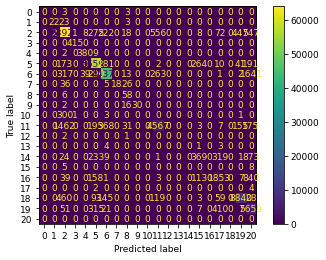

**************** LogisticRegression Model Testing ****************


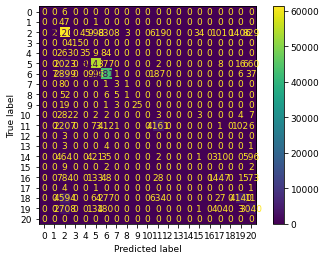

************** DecisionTreeClassifier Model Testing **************


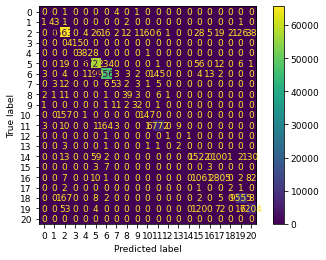

********** Gaussian Naive Bayes Classifier Model Testing **********


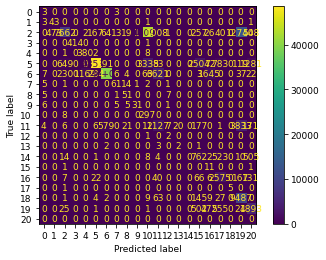

********* Bernoulli Naive Bayes Classifier Model Testing *********


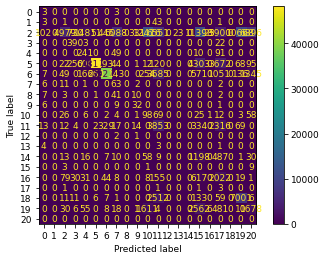

*********** Gradient Boosting Classifier Model Testing ***********


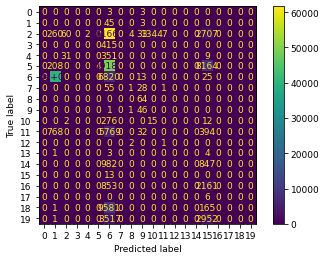

************* Random Forest Classifier Model Testing *************


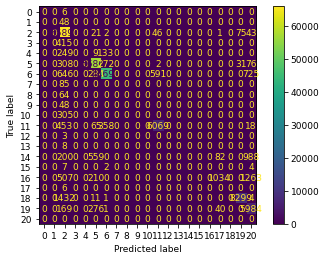

**************** XGBoost Classifier Model Testing ****************


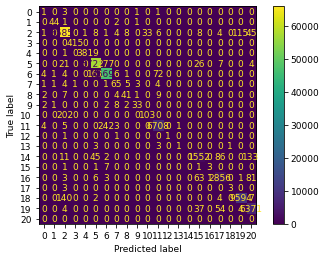

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

for name in models_1:
    print(line(name), name, 'Model Testing', line(name))
    plt.rc('font', size=9)  # 추가 코드 - 폰트 크기를 줄입니다
    ConfusionMatrixDisplay.from_predictions(y_test_1, preds_1[name])
    plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from lightgbm import LGBMClassifier

def line(name,sym="*"):
    return sym*(25-len(name)//2)

SEED=42
name = "LGBMClassifier"

lgbmc = LGBMClassifier(random_state=SEED)
lgbmc.fit(X_train_scaled_1, y_train_1)
lgbmc_predict = lgbmc.predict(X_test_scaled_1)

print(line(name), name, 'Model Testing', line(name))
# print(confusion_matrix(y_test_1, lgbmc_predict))
print(line(name,'-'))
print(classification_report(y_test_1, lgbmc_predict, zero_division=1.0))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.057559 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6776
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 41
[LightGBM] [Info] Start training from score -10.260162
[LightGBM] [Info] Start training from score -8.254829
[LightGBM] [Info] Start training from score -1.112230
[LightGBM] [Info] Start training from score -6.289871
[LightGBM] [Info] Start training from score -6.365431
[LightGBM] [Info] Start training from score -1.246445
[LightGBM] [Info] Start training from score -1.442505
[LightGBM] [Info] Start training from score -7.862267
[LightGBM] [Info] Start training from score -8.180721
[LightGBM] [Info] Start training from score -8.709565
[LightGBM] [Info] Start training from score -6.453500
[LightGBM] [Info] Start training from score -3.3617

### lightgbm 검증 데이터(early_stopping)

In [ ]:
from sklearn.model_selection import train_test_split

X_train,X_valid,Y_train,Y_valid=train_test_split(X_train_scaled_1, y_train_1, shuffle=False, test_size=0.2)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from lightgbm import LGBMClassifier
def line(name,sym="*"):
    return sym*(25-len(name)//2)
SEED=42
name = "LGBMClassifier"

lgbmc = LGBMClassifier(random_state=SEED, early_stopping=3)
lgbmc.fit(X_train, Y_train, eval_set=(X_valid, Y_valid))
lgbmc_predict = lgbmc.predict(X_test_scaled_1)

print(line(name), name, 'Model Testing', line(name))
# print(confusion_matrix(y_test_1, lgbmc_predict))
print(line(name,'-'))
print(classification_report(y_test_1, lgbmc_predict, zero_division=1.0))

[LightGBM] [Warning] early_stopping_round is set=3, early_stopping=3 will be ignored. Current value: early_stopping_round=3
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.045368 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6614
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 41
[LightGBM] [Warning] early_stopping_round is set=3, early_stopping=3 will be ignored. Current value: early_stopping_round=3
[LightGBM] [Info] Start training from score -10.191170
[LightGBM] [Info] Start training from score -8.221729
[LightGBM] [Info] Start training from score -1.111223
[LightGBM] [Info] Start training from score -6.256081
[LightGBM] [Info] Start training from score -6.333955
[LightGBM] [Info] Start training from score -1.246576
[LightGBM] [Info] Start training from score -1.441860
[LightGBM] [Info] S

### 단일 코드

Decision Tree

In [ ]:
# from sklearn.tree import DecisionTreeClassifier
# dtree_model = DecisionTreeClassifier(max_depth = 2).fit(X_train_scaled_1, y_train_1)
# dtree_predictions = dtree_model.predict(X_test_scaled_1)
# # creating a confusion matrix
# from sklearn.metrics import confusion_matrix
# cm = confusion_matrix(y_test_1, dtree_predictions)

SVM

In [ ]:
# from sklearn.svm import SVC
# svm_model_linear = SVC(kernel = 'linear', C = 1).fit(X_train_scaled_1, y_train_1)
# svm_predictions = svm_model_linear.predict(X_test_scaled_1)

# # model accuracy for X_test
# accuracy = svm_model_linear.score(X_test_scaled_1, y_test_1)
# # creating a confusion matrix
# cm = confusion_matrix(y_test_1, svm_predictions)

In [ ]:
# # SVM for Multiclass Predictions
# accuracy

KNN

In [ ]:
# from sklearn.neighbors import KNeighborsClassifier
# knn = KNeighborsClassifier(n_neighbors = 7).fit(X_train, y_train)

# # accuracy on X_test
# accuracy = knn.score(X_test, y_test)
# print accuracy

# # creating a confusion matrix
# knn_predictions = knn.predict(X_test)
# cm = confusion_matrix(y_test, knn_predictions)

Naive Bayes

In [ ]:
# from sklearn.naive_bayes import GaussianNB
# gnb = GaussianNB().fit(X_train, y_train)
# gnb_predictions = gnb.predict(X_test)

# # accuracy on X_test
# accuracy = gnb.score(X_test, y_test)
# print accuracy

# # creating a confusion matrix
# cm = confusion_matrix(y_test, gnb_predictions)

In [ ]:
# from sklearn.model_selection import cross_val_score
# models = {}
# models['SVC']= svc
# models['LogisticRegression']= lr
# models['DecisionTreeClassifier']= dtc
# models['Gaussian Naive Bayes Classifier']= gnb
# models['Bernoulli Naive Bayes Classifier']= bnb
# models['Gradient Boosting Classifier']= grb
# models['Random Forest Classifier']= rfe
# models['XGBoost Classifier']= xgbc
# models['LightGBM Classifier']= lgbmc
# scores = {}
# for name in models:
#   scores[name]={}
#   for scorer in ['precision','recall']:
#     scores[name][scorer] = cross_val_score(models[name], X_train_scaled_1, y_train_1, cv=2, scoring=scorer)

In [ ]:
# def line(name):
#   return '*'*(25-len(name)//2)

# for name in models:
#   print(line(name), name, 'Model Validation', line(name))

#   for scorer in ['precision','recall']:
#     mean = round(np.mean(scores[name][scorer])*100,2)
#     stdev = round(np.std(scores[name][scorer])*100,2)
#     print ("Mean {}:".format(scorer),"\n", mean,"%", "+-",stdev)
#     print()

In [ ]:
# for name in models:
#     for scorer in ['precision','recall']:
#         scores[name][scorer] = scores[name][scorer].mean()
# scores=pd.DataFrame(scores).swapaxes("index", "columns")*100
# scores.plot(kind = "bar",  ylim=[80,100], figsize=(24,6), rot=0)
# plt.savefig('precision-recall_1.png', bbox_inches='tight')

In [ ]:
# models = {}
# models['SVC']= svc
# models['LogisticRegression']= lr
# models['DecisionTreeClassifier']= dtc
# models['Gaussian Naive Bayes Classifier']= gnb
# models['Bernoulli Naive Bayes Classifier']= bnb
# models['Gradient Boosting Classifier']= grb
# models['Random Forest Classifier']= rfe
# models['XGBoost Classifier']= xgbc
# models['LightGBM Classifier']= lgbmc
# preds={}
# for name in models:
#     models[name].fit(X_train_scaled, y_train)
#     preds[name] = models[name].predict(X_test_scaled)
# print("Predictions complete.")

In [ ]:
# f1s = {}
# for name in models:
#     f1s[name]=f1_score(y_test, preds[name])
# f1s=pd.DataFrame(f1s.values(),index=f1s.keys(),columns=["F1-score"])*100
# f1s.plot(kind = "bar",  ylim=[80,100], figsize=(16,6), rot=0)
# plt.savefig('f1-score.png', bbox_inches='tight')

## Deep Learning Approach for MClass Detection

In [ ]:
import pandas
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
# from tensorflow.keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

In [ ]:
# estimator = KerasClassifier(build_fn=baseline_model, epochs=100, batch_size=80, verbose=1)

In [ ]:
# from sklearn.preprocessing import StandardScaler, MinMaxScaler
# scaler = MinMaxScaler()
# # store the columns
# cols = X1.columns
# # transform the data
# X1_dl = scaler.fit_transform(X1)
# X1_dl = pd.DataFrame(X1_dl, columns = cols)

# kfold = KFold(n_splits=2, shuffle=True)
# results = cross_val_score(estimator, X1_dl, Y1, cv=kfold)
# print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

In [ ]:
model = Sequential()
model.add(Dense(40, input_dim=43, activation='relu'))
model.add(Dense(35, activation = 'relu'))
model.add(Dense(30, activation = 'relu'))
model.add(Dense(25, activation = 'relu'))
model.add(Dense(21, activation='softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = MinMaxScaler()
# store the columns
cols = X1.columns
# transform the data
X1_dl = scaler.fit_transform(X1)
X1_dl = pd.DataFrame(X1_dl, columns = cols)

from tensorflow.keras.utils import to_categorical
y_cat = to_categorical(Y1)

In [ ]:
from sklearn.model_selection import train_test_split
x_train_dl, x_test_dl, y_train_dl, y_test_dl = train_test_split(X1_dl, y_cat, test_size=0.2)

In [ ]:
k = model.fit(x_train_dl ,y_train_dl, verbose=1, epochs=100, batch_size=128)

# kfold = KFold(n_splits=2, shuffle=True)
# results = cross_val_score(estimator, X1_dl, Y1, cv=kfold)

In [ ]:
mean = sum(k.history['accuracy']) / len(k.history['accuracy'])
variance = sum([((x - mean) ** 2) for x in k.history['accuracy']]) / len(k.history['accuracy'])
res = variance ** 0.5
print("Baseline: %.2f%% (%.2f%%)" % (mean*100, res*100))

In [ ]:
df1['Attack'].unique()

In [ ]:
# y_pred_class = mod.predict(x_test_dl)
from sklearn.metrics import confusion_matrix
y_pred = model.predict(x_test_dl)
y_pred_class = y_pred.argmax(axis=-1)
y_test_class = np.argmax(y_test_dl, axis=1)
from sklearn.metrics import classification_report
print(classification_report(y_test_class, y_pred_class))

In [ ]:
set(y_test_class) - set(y_pred_class)

In [ ]:
from matplotlib import pyplot
pyplot.plot(k.history['accuracy'])
pyplot.savefig('DL_NN_Accuracy_EpochVsAccuracy.jpg',dpi=900)
pyplot.show()

In [ ]:
import subprocess
from ast import literal_eval

def run(command):
    process = subprocess.Popen(command, shell=True, stdout=subprocess.PIPE)
    out, err = process.communicate()
    print(out.decode('utf-8').strip())

In [ ]:
print('# CPU')
run('cat /proc/cpuinfo | egrep -m 1 "^model name"')
run('cat /proc/cpuinfo | egrep -m 1 "^cpu MHz"')
run('cat /proc/cpuinfo | egrep -m 1 "^cpu cores"')

In [ ]:
print('# RAM')
run('cat /proc/meminfo | egrep "^MemTotal"')

In [ ]:
print('# OS')
run('uname -a')

In [ ]:
print('# GPU')
run('lspci | grep VGA')